In [30]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from processing_PCA import pca, preprocessor, X_train,y_train, X_test, y_test
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
import joblib

In [19]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42)
}

results = {}
pipelines = {}

In [ ]:
for name, clf in models.items():
    print("="*70)
    print(f"Training {name} with preprocessing + PCA pipeline...")
    
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('pca', pca),
        ('classifier', clf)
    ])
    
    pipe.fit(X_train, y_train)
    
    y_pred = pipe.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    
    results[name] = acc
    pipelines[name] = pipe

Training Logistic Regression with preprocessing + PCA pipeline...

Logistic Regression Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        23

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32

Confusion Matrix:
 [[ 9  0]
 [ 0 23]]
Training Decision Tree with preprocessing + PCA pipeline...

Decision Tree Accuracy: 0.8125
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.67      0.67         9
           1       0.87      0.87      0.87        23

    accuracy                           0.81        32
   macro avg       0.77      0.77      0.77        32
weighted avg       0.81      0.81      0.81        32

Confusion Matrix:
 [[ 6  3]
 [ 3 20]]
Training Random Forest wit

In [21]:
print("\n" + "="*70)
print("Model Performance Summary:")
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")


Model Performance Summary:
Logistic Regression: 1.0000
Decision Tree: 0.8125
Random Forest: 0.8438
SVM: 0.9688


In [32]:
best_model_name = max(results, key=results.get)
best_pipeline = pipelines[best_model_name]
print(f"\nBest model: {best_model_name}")


Best model: Logistic Regression



Confusion Matrix for Best Model:


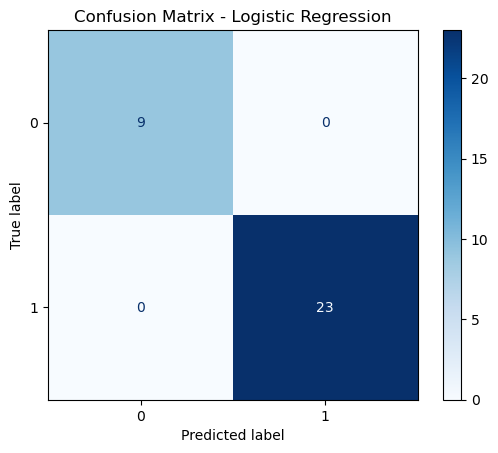

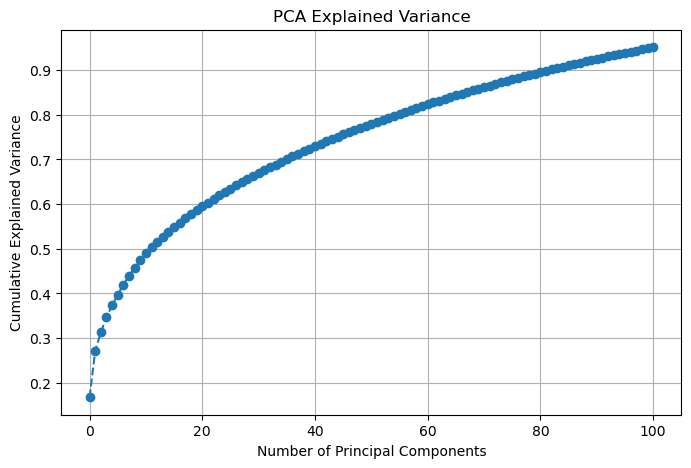

In [33]:
print("\nConfusion Matrix for Best Model:")
ConfusionMatrixDisplay.from_estimator(best_pipeline, X_test, y_test, cmap="Blues")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()

# PCA explained variance plot
try:
    plt.figure(figsize=(8, 5))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Explained Variance')
    plt.grid(True)
    plt.show()
except AttributeError:
    print("PCA variance plot unavailable (PCA may be refit inside pipeline).")

In [35]:
best_model_name = max(results, key=results.get)
print(f"Starting GridSearchCV for best model: {best_model_name}")

if best_model_name == "Random Forest":
    param_grid = {
        'pca__n_components': [0.90, 0.95, 0.99],
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [5, 10, 20, None],
        'classifier__min_samples_split': [2, 5, 10]
    }
    base_clf = RandomForestClassifier(random_state=42)

elif best_model_name == "Decision Tree":
    param_grid = {
        'pca__n_components': [0.90, 0.95, 0.99],
        'classifier__max_depth': [3, 5, 10, None],
        'classifier__min_samples_split': [2, 5, 10]
    }
    base_clf = DecisionTreeClassifier(random_state=42)

elif best_model_name == "Logistic Regression":
    param_grid = {
        'pca__n_components': [0.90, 0.95, 0.99],
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__solver': ['lbfgs', 'liblinear']
    }
    base_clf = LogisticRegression(max_iter=1000, random_state=42)

else:  
    param_grid = {
        'pca__n_components': [0.90, 0.95, 0.99],
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__kernel': ['linear', 'rbf']
    }
    base_clf = SVC(random_state=42)

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', pca),
    ('classifier', base_clf)
])

grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("\nBest Parameters Found:")
print(grid_search.best_params_)
print(f"Best CV Score: {grid_search.best_score_:.4f}")

Starting GridSearchCV for best model: Logistic Regression
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best Parameters Found:
{'classifier__C': 10.0, 'classifier__solver': 'lbfgs', 'pca__n_components': 0.99}
Best CV Score: 0.9843


In [28]:
best_pipeline = grid_search.best_estimator_
y_pred = best_pipeline.predict(X_test)

print("\nTest Set Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Test Set Performance:
Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        23

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32


Confusion Matrix:
 [[ 9  0]
 [ 0 23]]


In [ ]:
joblib.dump(best_pipeline, "best_disease_pipeline.pkl")
print("Saved model as best_disease_pipeline.pkl!")

Saved model as best_disease_pipeline.pkl
